# PlantSpy 1- Premiers Modeles : Classification par espece

## Importer les librairies et connection au Drive

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm

from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Recuperation des donnees:


#### Train Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/train/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/train/"

X_train0=[]
y_train0=[]
y2_train0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      chemin=folder_path+repertoire
      for images in os.listdir(chemin):
        img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
        img_resized = cv2.resize(img, (width,height))
        X_train0.append(np.array(img_resized))
        y_train0.append(repertoire.split('___')[0])   # On recupere la categorie de plante
        y2_train0.append(repertoire.split('___')[1]) # On recupere la maladie


In [ ]:
dftc = pd.DataFrame(y_train0, columns =["categorie"] ) #(70295, 3)
dftm = pd.DataFrame(y2_train0, columns =["maladie"] )
df_tot_t = pd.concat([dftc, dftm], axis=1)
df_tot_t['healthy']=(df_tot_t['maladie']=="healthy")*1
df_tot_t.to_csv('/content/drive/MyDrive/PlantSpy_Prez_Material/DataSet_Train.csv')
df_tot_t.head()

,categorie,maladie,healthy
0,Apple,Apple_scab,0
1,Apple,Apple_scab,0
2,Apple,Apple_scab,0
3,Apple,Apple_scab,0
4,Apple,Apple_scab,0


In [ ]:
X_train0 = np.array(X_train0)
X_train0 = X_train0.astype('float32')


In [ ]:
y_train0= np.array(y_train0)
y2_train0= np.array(y2_train0)

In [ ]:
pd.DataFrame(y_train0).value_counts()

Tomato                     18345
Apple                       7771
Corn_(maize)                7316
Grape                       7222
Potato                      5702
Pepper,_bell                3901
Strawberry                  3598
Peach                       3566
Cherry_(including_sour)     3509
Soybean                     2022
Orange                      2010
Blueberry                   1816
Raspberry                   1781
Squash                      1736
dtype: int64

#### Valid Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/valid/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y_valid0=[]
y2_valid0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      chemin=folder_path+repertoire
      for images in os.listdir(chemin):
        img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
        img_resized = cv2.resize(img, (width,height)) 
        X_valid0.append(np.array(img_resized))
        y_valid0.append(repertoire.split('___')[0])   # On recupere la categorie de plante
        y2_valid0.append(repertoire.split('___')[1]) # On recupere la maladie



In [ ]:
X_valid0= np.array(X_valid0)
X_valid0 = X_valid0.astype('float32')

y_valid0= np.array(y_valid0)
y2_valid0= np.array(y2_valid0)

In [ ]:
X_valid0.shape

(17572, 100, 100, 3)

In [ ]:
data = []
data.append([y_valid0, y2_valid0])


In [ ]:
dfc = pd.DataFrame(y_valid0, columns =["categorie"] ) #(70295, 3)
dfm = pd.DataFrame(y2_valid0, columns =["maladie"] )

In [ ]:
dfc = pd.DataFrame(y_valid0, columns =["categorie"] ) #(70295, 3)
dfm = pd.DataFrame(y2_valid0, columns =["maladie"] )
df_tot = pd.concat([dfc, dfm], axis=1)
df_tot['healthy']=(df_tot['maladie']=="healthy")*1
df_tot.to_csv('/content/drive/MyDrive/PlantSpy_Prez_Material/DataSet_Valid.csv')
df_tot.head()

,categorie,maladie,healthy
0,Apple,Apple_scab,0
1,Apple,Apple_scab,0
2,Apple,Apple_scab,0
3,Apple,Apple_scab,0
4,Apple,Apple_scab,0


In [ ]:
pd.DataFrame(y_valid0).value_counts()

Tomato                     4585
Apple                      1943
Corn_(maize)               1829
Grape                      1805
Potato                     1426
Pepper,_bell                975
Strawberry                  900
Peach                       891
Cherry_(including_sour)     877
Soybean                     505
Orange                      503
Blueberry                   454
Raspberry                   445
Squash                      434
dtype: int64

## DataViz

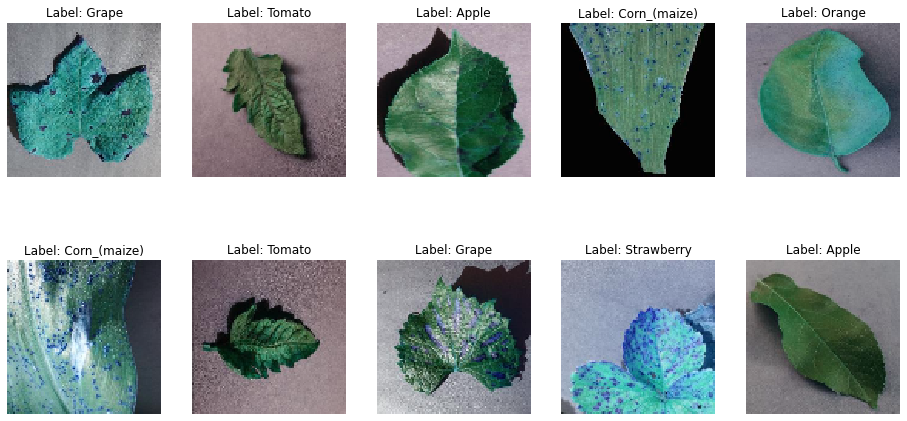

In [ ]:
plt.subplots(2, 5, figsize=(16, 8))

j = 1


for i in np.random.choice(np.arange(0, len(X_train0)), size = 10):
    # Image
    img =X_train0[i]/255
    
    
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(2, 5, j)
    j = j + 1
    
    # Suppresion des axes
    plt.axis('off')
    
    # Affichage de la figure
    plt.imshow(img, interpolation='None')

    # Modification du titre de la figure
    plt.title('Label: ' + str(y_train0[i]))

In [ ]:
for i in np.random.choice(np.arange(0, 15), size = 10):
  print(i)

13
6
7
14
6
14
13
5
13
13


Text(0.5, 1.0, 'Label:Tomato')

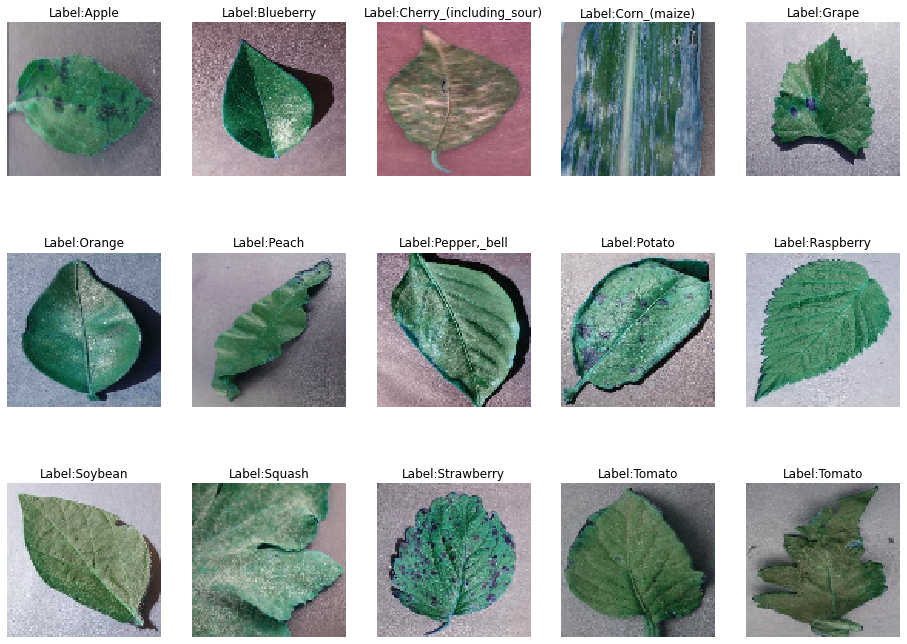

In [ ]:
Liste_plantes=['Apple','Blueberry','Cherry_(including_sour)', 'Corn_(maize)', 'Grape','Orange','Peach', 'Pepper,_bell', 'Potato', 'Raspberry','Soybean', 'Squash', 'Strawberry', 'Tomato']
plt.subplots(3, 5, figsize=(16, 12))


k=np.random.choice(np.arange(0, 400), size=14)

for i in range(0,14):
  plt.subplot(3, 5, i+1)
  plt.axis('off')
  img=X_valid0[y_valid0==Liste_plantes[i]][k[i]]/255
  plt.imshow(img, interpolation='None')
  plt.title('Label:'+str(Liste_plantes[i]))

plt.subplot(3, 5, 15)
plt.axis('off')
img=X_valid0[y_valid0=="Tomato"][k[1]]/255
plt.imshow(img, interpolation='None')
plt.title('Label:'+str("Tomato"))



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


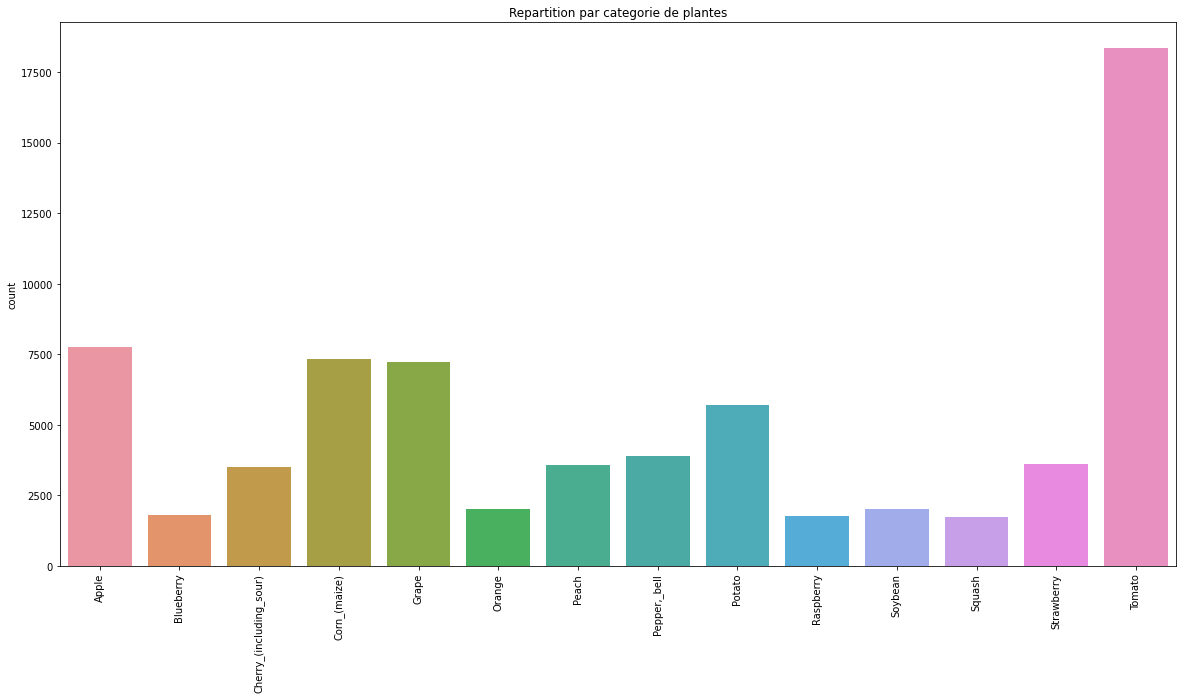

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))
plt.title("Repartition par categorie de plantes")

sns.countplot(y_train0)
plt.xticks(rotation=90);

In [ ]:
pd.DataFrame(y_train0).value_counts()

Tomato                     18345
Apple                       7771
Corn_(maize)                7316
Grape                       7222
Potato                      5702
Pepper,_bell                3901
Strawberry                  3598
Peach                       3566
Cherry_(including_sour)     3509
Soybean                     2022
Orange                      2010
Blueberry                   1816
Raspberry                   1781
Squash                      1736
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


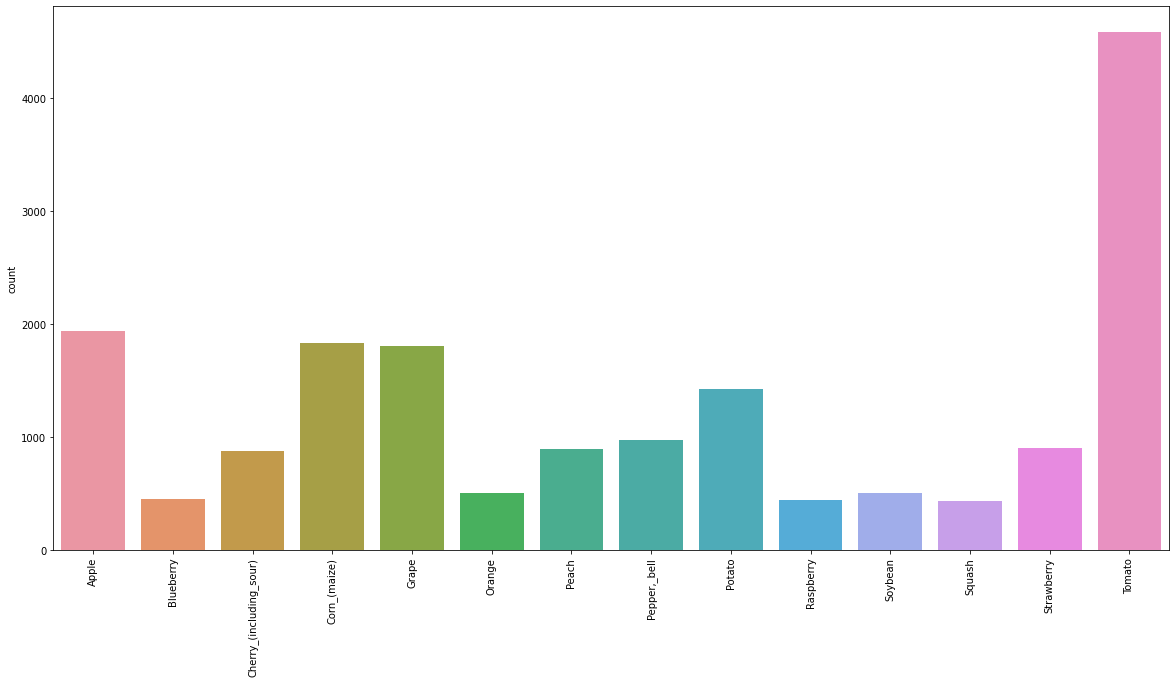

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.countplot(y_valid0)
plt.xticks(rotation=90);

In [ ]:
pd.DataFrame(y_valid0).value_counts()

Tomato                     4585
Apple                      1943
Corn_(maize)               1829
Grape                      1805
Potato                     1426
Pepper,_bell                975
Strawberry                  900
Peach                       891
Cherry_(including_sour)     877
Soybean                     505
Orange                      503
Blueberry                   454
Raspberry                   445
Squash                      434
dtype: int64

In [ ]:

pd.DataFrame(y2_train0).value_counts()


healthy                                 22294
Bacterial_spot                           5453
Black_rot                                3875
Early_blight                             3859
Late_blight                              3790
Powdery_mildew                           3419
Apple_scab                               2016
Haunglongbing_(Citrus_greening)          2010
Tomato_Yellow_Leaf_Curl_Virus            1961
Esca_(Black_Measles)                     1920
Northern_Leaf_Blight                     1908
Common_rust_                             1907
Leaf_Mold                                1882
Target_Spot                              1827
Tomato_mosaic_virus                      1790
Leaf_scorch                              1774
Cedar_apple_rust                         1760
Septoria_leaf_spot                       1745
Spider_mites Two-spotted_spider_mite     1741
Leaf_blight_(Isariopsis_Leaf_Spot)       1722
Cercospora_leaf_spot Gray_leaf_spot      1642
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


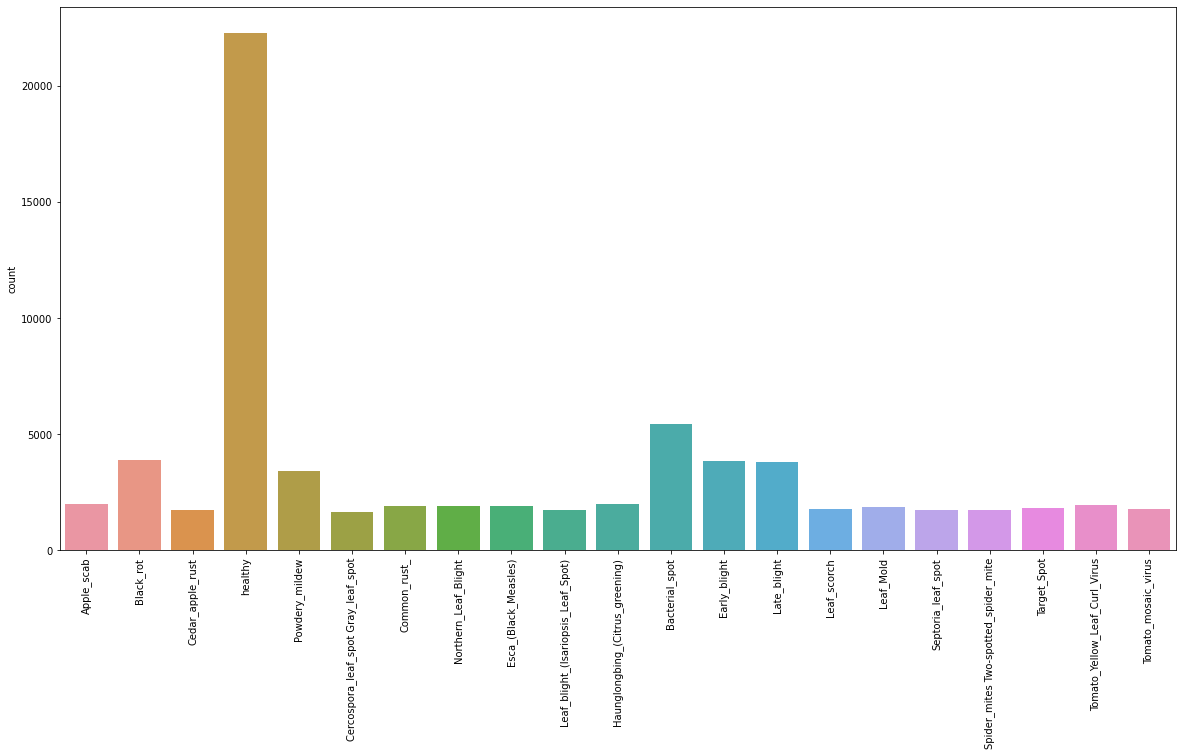

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.countplot(y2_train0)
plt.xticks(rotation=90);

In [ ]:


df1=pd.DataFrame(y_train0, columns=['categorie'])
df2=pd.DataFrame(y2_train0, columns=['maladie'])

df=pd.concat([df1,df2], axis=1)
df["healthy"]=df['maladie']=="healthy"


No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


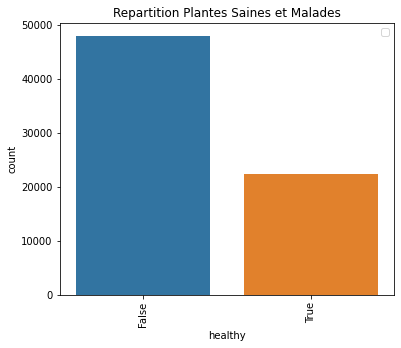

In [ ]:
plt.figure(figsize=(6, 5))
plt.title("Repartition Plantes Saines et Malades")
plt.legend()

sns.countplot(df['healthy'])
plt.xticks(rotation=90);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


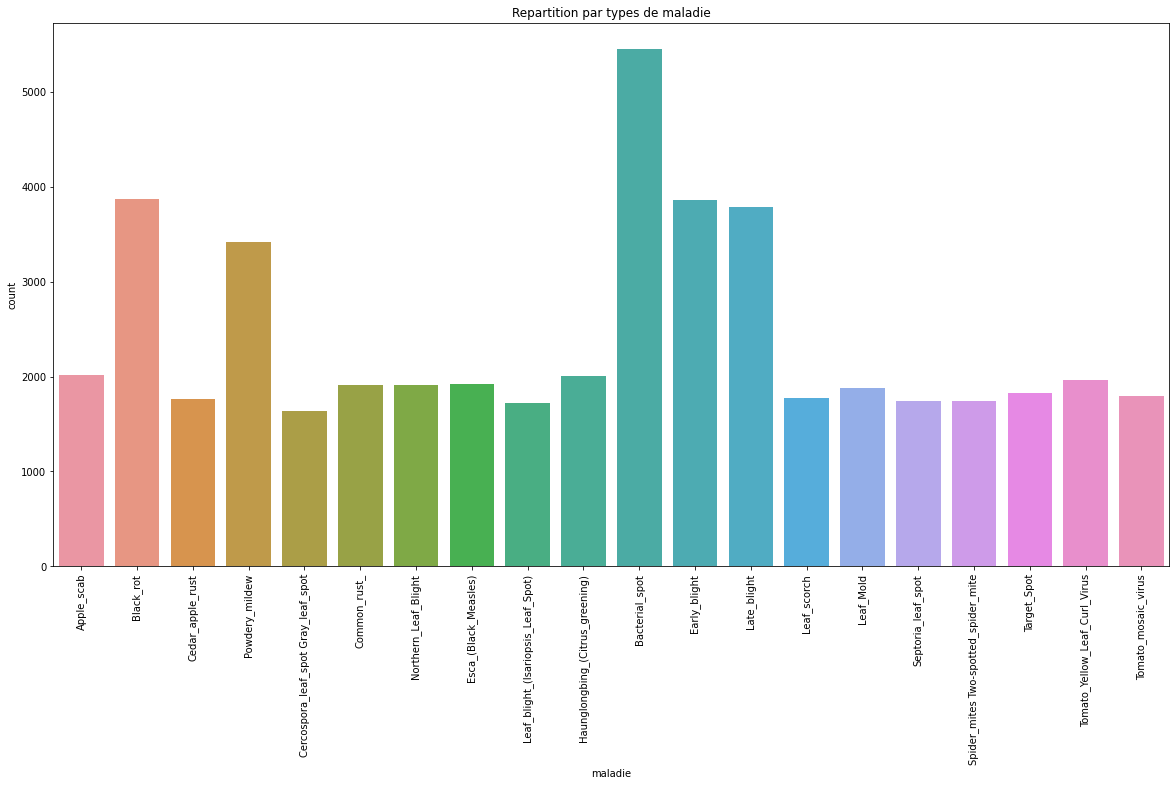

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Repartition par types de maladie")

sns.countplot(df[df['healthy']==0]['maladie'])
plt.xticks(rotation=90);

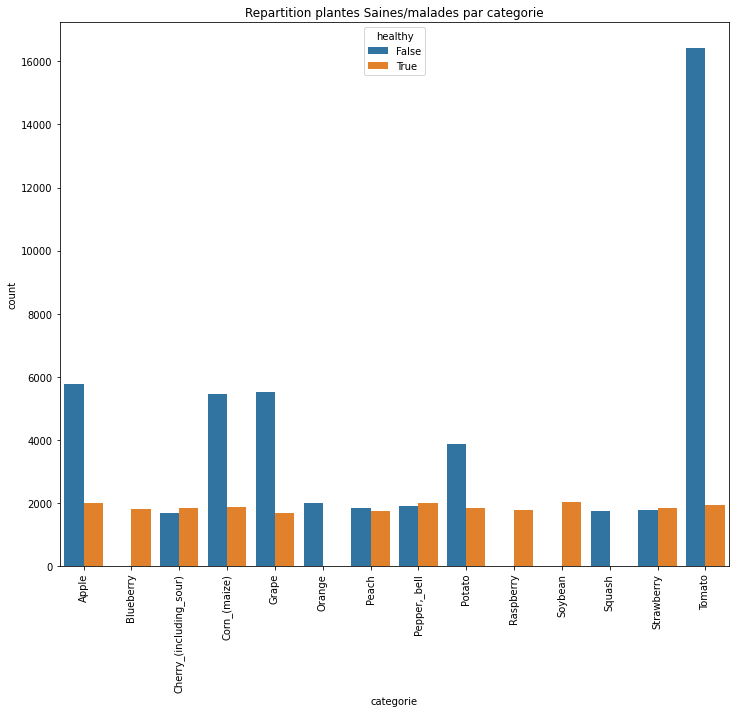

In [ ]:
plt.figure(figsize=(12, 10))
plt.title("Repartition plantes Saines/malades par categorie")

sns.countplot(x="categorie", hue="healthy", data=df)
plt.xticks(rotation=90);

In [ ]:
print(df.groupby("categorie").sum('healthy'))

                         healthy
categorie                       
Apple                        502
Blueberry                    454
Cherry_(including_sour)      456
Corn_(maize)                 465
Grape                        423
Orange                         0
Peach                        432
Pepper,_bell                 497
Potato                       456
Raspberry                    445
Soybean                      505
Squash                         0
Strawberry                   456
Tomato                       481


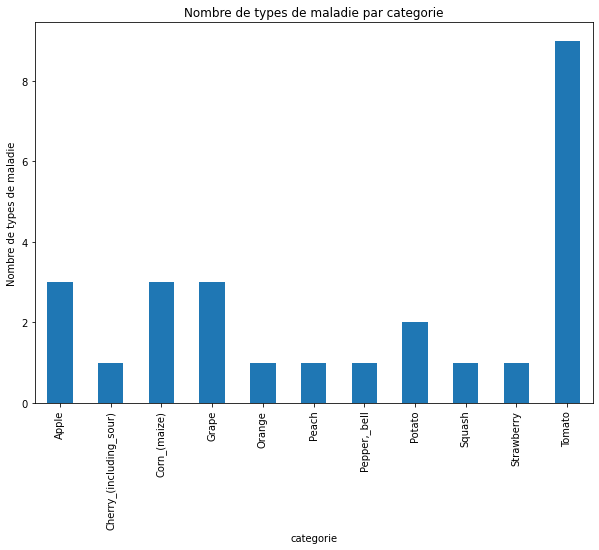

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Nombre de types de maladie par categorie")
plt.ylabel("Nombre de types de maladie")
df[df['healthy']==0].groupby("categorie").maladie.nunique().plot.bar()

In [ ]:
df[df['healthy']==0].groupby("categorie").maladie.nunique()

categorie
Apple                      3
Cherry_(including_sour)    1
Corn_(maize)               3
Grape                      3
Orange                     1
Peach                      1
Pepper,_bell               1
Potato                     2
Squash                     1
Strawberry                 1
Tomato                     9
Name: maladie, dtype: int64

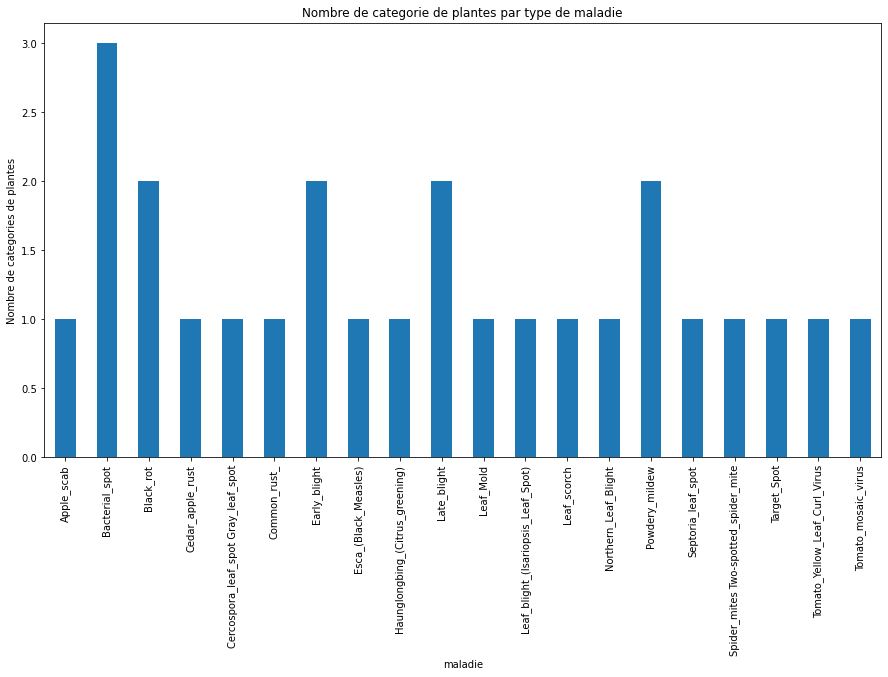

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Nombre de categorie de plantes par type de maladie")
plt.ylabel("Nombre de categories de plantes")
df[df['healthy']==0].groupby("maladie").categorie.nunique().plot.bar()

## Preprocessing

In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
X_train = X_train0 / 255
X_valid = X_valid0 / 255

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train0)
y_valid = encoder.transform(y_valid0)

In [ ]:
# Pour retrouver facilement les noms des labels
dict_categorie = {0 : 'Apple', 1 : 'Blueberry', 2: 'Cherry', 3: 'Corn', 4: 'Grape', 5:'Orange', 6: 'Peach',
        7: 'Pepper', 8: 'Potato', 9: 'Raspberry', 10: 'Soybean', 11:'Squash', 12:'Strawberry', 13:'Tomato'}

In [ ]:
# Shape of X_train and y_train
print('Shape of X Train:', X_train.shape)
print('Shape of y train:',y_train.shape)

print('Shape of X valid:', X_valid.shape)
print('Shape of y valid:',y_valid.shape)

In [ ]:
# UnderSampling:

# Changement de forme
X_train_reshaped = X_train.reshape([-1, 100*100*3])


sampling_strategy =  { 0: 1200,  1: 1200, 2: 1200, 3: 1200, 4: 1200 , 5: 1200 , 6: 1200, 7: 1200, 8: 1200, 9: 1200, 10: 1200, 11:1200, 12: 1200, 13: 1200}

rUs=RandomUnderSampler(sampling_strategy= sampling_strategy , random_state=222)
# rUs=RandomUnderSampler(random_state=222)

(X_train_ru2,y_train_ru2) = rUs.fit_resample(X_train_reshaped, y_train)


print('Classes échantillon undersampled :', dict(pd.Series(y_train_ru2).value_counts()))

# Changement de forme
X_train_ru2 = X_train_ru2.reshape([-1, 100,100,3])

# Shape of X_train and y_train
print('Shape of X Train:', X_train_ru2.shape)
print('Shape of y train:',y_train.shape)



# Callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

# Generateur de donnees

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
batch_size = 100

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

In [ ]:
batch_size = 100

training_data_ru = train_data_generator.flow(X_train_ru2, y_train_ru2, batch_size=batch_size)
test_data = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

## Generateur de donnees UnderSampling

In [ ]:
batch_size = 100

training_data_ru2= train_data_generator.flow(X_train_ru2, y_train_ru2, batch_size=batch_size)
test_data_ru2 = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

# 1er Modele Baseline - Convolutional Neural Networks (CNN) Classique


#### Architecture, Compilation et entrainement du modele

In [ ]:
inputs = Input(shape = (100, 100, 3), name = "Input")

first_layer = Conv2D(filters = 32,              #La couche sera composée de 32 matrices de convolution.  
                     kernel_size = (5, 5),      #le noyau de convolution sera de dimension 5x5 (25 neuronnes par filtre).
                     padding = 'valid',         #pour que le noyau ne puisse pas dépasser les bords de l'image. 
                     activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2)) #pour que le maximum soit calculé sur des morceaux de dimensions 2x2.

third_layer = Dropout(rate = 0.2)               # Dropout avec paramètre rate = 0.2 pour couper 20% des connections

fourth_layer = Flatten()                        # Couche d'applatissement  (pour aplatir une matrice en un vecteur). 

fifth_layer = Dense(units = 128,                # couche Dense avec 128 neurones et la fonction d'activation ReLU
                    activation = 'relu')

output_layer = Dense(units = 14,                # output_layer= couche dense  avec 14 neurones (pour 14 especes du dataset) 
                     activation='softmax')      # une fonction d'activation softmax pour renvoyer des prédictions de probabilité pour chaque classe

# on ajoute toutes ces couches au modèle
x=first_layer(inputs)
x=second_layer(x)
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)

outputs=output_layer(x)

modelCNN1 = Model(inputs = inputs, outputs = outputs)



In [ ]:
# Compilation du modèle
modelCNN1.compile(loss='sparse_categorical_crossentropy',   # fonction de perte 'categorical_crossentropy' ou  "sparse_categorical_crossentropy"?????
              optimizer='adam',                         # algorithme d'optimisation = l'algorithme de descente de gradient 'adam' comme optimizer
              metrics=['accuracy'])                     # métrique d'évaluation Accuracy


In [ ]:
modelCNN1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               9437312   
                                                           

In [ ]:
# Entraînement du modèle 
training_history_CNN1 = modelCNN1.fit(X_train, y_train,          # données d'entraînement
                             epochs = 10,               # nombre d'epochs
                             batch_size = 200,           # taille des batchs
                             validation_split = 0.2)    # proportion de l'échantillon de test

Epoch 1/10
282/282 [==============================] - 233s 826ms/step - loss: 1.2600 - accuracy: 0.6371 - val_loss: 1.7697 - val_accuracy: 0.4775
Epoch 2/10
282/282 [==============================] - 232s 823ms/step - loss: 0.4735 - accuracy: 0.8474 - val_loss: 2.9232 - val_accuracy: 0.2660
Epoch 3/10
282/282 [==============================] - 233s 826ms/step - loss: 0.2980 - accuracy: 0.9030 - val_loss: 2.2380 - val_accuracy: 0.4563
Epoch 4/10
282/282 [==============================] - 236s 835ms/step - loss: 0.2089 - accuracy: 0.9336 - val_loss: 3.3168 - val_accuracy: 0.3205
Epoch 5/10
282/282 [==============================] - 237s 839ms/step - loss: 0.1447 - accuracy: 0.9547 - val_loss: 3.0263 - val_accuracy: 0.3859
Epoch 6/10
282/282 [==============================] - 240s 852ms/step - loss: 0.1058 - accuracy: 0.9674 - val_loss: 3.4443 - val_accuracy: 0.3733
Epoch 7/10
282/282 [==============================] - 236s 836ms/step - loss: 0.0821 - accuracy: 0.9748 - val_loss: 4.6631 -

####  Performances du modèle:

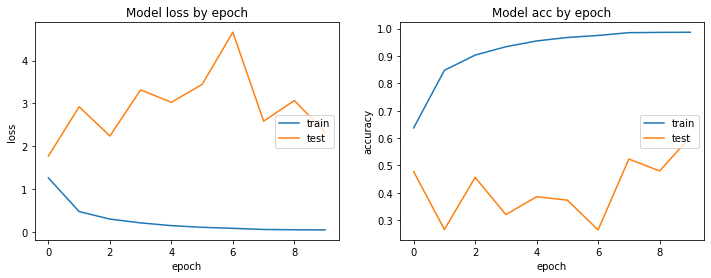

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(training_history_CNN1.history['loss'])
plt.plot(training_history_CNN1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(training_history_CNN1.history['accuracy'])
plt.plot(training_history_CNN1.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Classification Report et Matrice de confusion

In [ ]:
test_pred_CNN1 = modelCNN1.predict(X_valid)

test_pred_CNN1_class = test_pred_CNN1.argmax(axis = 1)
# y_test_class = y_test.argmax(axis = 1)


In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_CNN1_label = (pd.DataFrame(test_pred_CNN1_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label , test_pred_CNN1_label))

              precision    recall  f1-score   support

       Apple       0.76      0.76      0.76      1943
   Blueberry       0.75      0.87      0.81       454
      Cherry       0.66      0.97      0.78       877
        Corn       0.96      0.95      0.96      1829
       Grape       0.95      0.95      0.95      1805
      Orange       0.97      0.87      0.92       503
       Peach       0.72      0.88      0.79       891
      Pepper       0.84      0.75      0.80       975
      Potato       0.68      0.92      0.78      1426
   Raspberry       0.79      0.90      0.84       445
     Soybean       0.92      0.86      0.89       505
      Squash       0.83      0.97      0.90       434
  Strawberry       0.94      0.84      0.89       900
      Tomato       0.88      0.68      0.77      4585

    accuracy                           0.83     17572
   macro avg       0.83      0.87      0.85     17572
weighted avg       0.84      0.83      0.83     17572



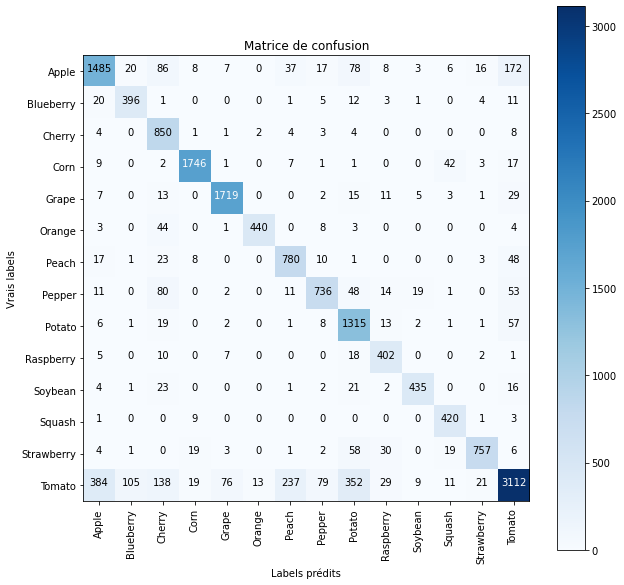

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_CNN1_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

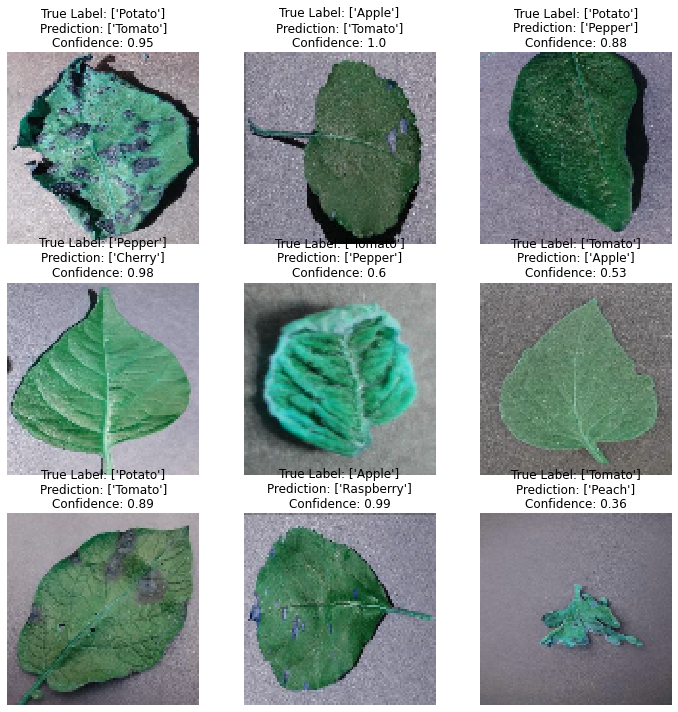

In [ ]:
# voir les images de la base de test où le modele se trompe

plt.subplots(3, 3, figsize=(12, 12))

error_indexes = []
for i in range(len(test_pred_CNN1)):
    if (test_pred_CNN1_class[i] != y_valid[i]):
      error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 9):
    img = X_valid[i] 
    img = img.reshape(100, 100,3)
    
    plt.subplot(3, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_valid_label[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_CNN1_label[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred_CNN1[i,test_pred_CNN1_class[i]], 2)))



# 2e Modele - Convolutional Neural Networks (CNN) - avec generateur d'images


#### Architecture, Compilation et entrainement du modele

In [ ]:
inputs = Input(shape = (100, 100, 3), name = "Input")

first_layer = Conv2D(filters = 32,              #La couche sera composée de 32 matrices de convolution.  
                     kernel_size = (5, 5),      #le noyau de convolution sera de dimension 5x5 (25 neuronnes par filtre).
                     padding = 'valid',         #pour que le noyau ne puisse pas dépasser les bords de l'image. 
                     activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2)) #pour que le maximum soit calculé sur des morceaux de dimensions 2x2.

third_layer = Dropout(rate = 0.2)               # Dropout avec paramètre rate = 0.2 pour couper 20% des connections

fourth_layer = Flatten()                        # Couche d'applatissement  (pour aplatir une matrice en un vecteur). 

fifth_layer = Dense(units = 128,                # couche Dense avec 128 neurones et la fonction d'activation ReLU
                    activation = 'relu')

output_layer = Dense(units = 14,                # output_layer= couche dense  avec 14 neurones (pour 14 especes du dataset) 
                     activation='softmax')      # une fonction d'activation softmax pour renvoyer des prédictions de probabilité pour chaque classe

# on ajoute toutes ces couches au modèle
x=first_layer(inputs)
x=second_layer(x)
x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)

outputs=output_layer(x)

modelCNN2 = Model(inputs = inputs, outputs = outputs)



In [ ]:
# Compilation du modèle
modelCNN2.compile(loss='sparse_categorical_crossentropy',   # fonction de perte 'categorical_crossentropy' ou  "sparse_categorical_crossentropy"?????
              optimizer='adam',                         # algorithme d'optimisation = l'algorithme de descente de gradient 'adam' comme optimizer
              metrics=['accuracy'])                     # métrique d'évaluation Accuracy


In [ ]:
modelCNN2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               9437312   
                                                             

In [ ]:
history_CNN2 = modelCNN2.fit_generator(generator = training_data, 
                              epochs = 20,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
702/702 [==============================] - 470s 669ms/step - loss: 0.6918 - accuracy: 0.7658 - val_loss: 0.6092 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 2/20
702/702 [==============================] - 486s 692ms/step - loss: 0.6077 - accuracy: 0.7950 - val_loss: 0.5078 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 3/20
702/702 [==============================] - 463s 660ms/step - loss: 0.5599 - accuracy: 0.8102 - val_loss: 0.4755 - val_accuracy: 0.8425 - lr: 0.0010
Epoch 4/20
702/702 [==============================] - 463s 660ms/step - loss: 0.5123 - accuracy: 0.8266 - val_loss: 0.4393 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 5/20
702/702 [==============================] - 482s 686ms/step - loss: 0.4751 - accuracy: 0.8388 - val_loss: 0.4285 - val_accuracy: 0.8541 - lr: 0.0010
Epoch 6/20
702/702 [==============================] - 472s 672ms/step - loss: 0.4500 - accuracy: 0.8472 - val_loss: 0.3904 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 7/20
702/702 [==========================

####  Performances du modèle:

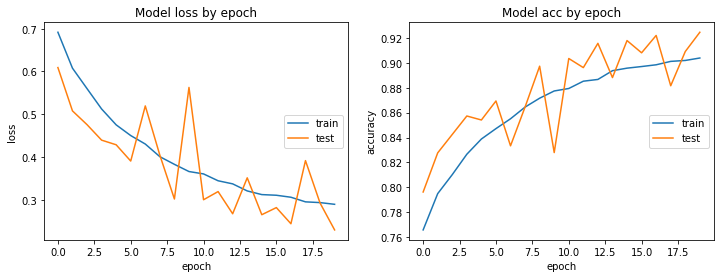

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_CNN2.history['loss'])
plt.plot(history_CNN2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_CNN2.history['accuracy'])
plt.plot(history_CNN2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Classification Report et Matrice de confusion

In [ ]:
test_pred_CNN2 = modelCNN2.predict(X_valid)

test_pred_CNN2_class = test_pred_CNN2.argmax(axis = 1)
# y_test_class = y_test.argmax(axis = 1)


In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_CNN2_label = (pd.DataFrame(test_pred_CNN2_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label , test_pred_CNN2_label))

              precision    recall  f1-score   support

       Apple       0.93      0.84      0.88      1943
   Blueberry       0.86      0.91      0.88       454
      Cherry       0.91      0.94      0.93       877
        Corn       0.99      0.96      0.97      1829
       Grape       0.98      0.97      0.97      1805
      Orange       0.97      0.93      0.95       503
       Peach       0.93      0.88      0.90       891
      Pepper       0.93      0.83      0.88       975
      Potato       0.79      0.96      0.87      1426
   Raspberry       0.85      0.95      0.90       445
     Soybean       1.00      0.83      0.91       505
      Squash       0.94      0.98      0.96       434
  Strawberry       0.96      0.94      0.95       900
      Tomato       0.92      0.94      0.93      4585

    accuracy                           0.92     17572
   macro avg       0.93      0.92      0.92     17572
weighted avg       0.93      0.92      0.92     17572



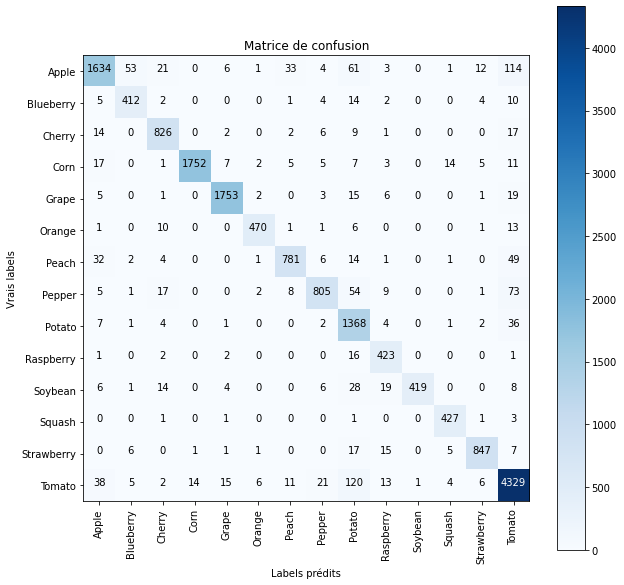

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_CNN2_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

# 3e Modele: Architecture LeNet avec generateur d'images

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_LeNet1 = Sequential()
model_LeNet1.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(3, 3)))
model_LeNet1.add(Dropout(rate=0.2))
model_LeNet1.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1.add(Dropout(rate=0.2))
model_LeNet1.add(Flatten())
model_LeNet1.add(Dense(units=64, activation='relu'))
model_LeNet1.add(Dense(units=14, activation='softmax'))

In [ ]:
model_LeNet1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_LeNet1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 30)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        1

In [ ]:
history_LeNet1 = model_LeNet1.fit_generator(generator = training_data, 
                              epochs = 20,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
702/702 [==============================] - 538s 765ms/step - loss: 1.4578 - accuracy: 0.5215 - val_loss: 0.9569 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 2/20
702/702 [==============================] - 541s 770ms/step - loss: 0.8358 - accuracy: 0.7192 - val_loss: 0.6776 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/20
702/702 [==============================] - 552s 787ms/step - loss: 0.6374 - accuracy: 0.7846 - val_loss: 0.4320 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 4/20
702/702 [==============================] - 569s 811ms/step - loss: 0.5393 - accuracy: 0.8161 - val_loss: 0.4147 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 5/20
702/702 [==============================] - 573s 816ms/step - loss: 0.4606 - accuracy: 0.8447 - val_loss: 0.4693 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 6/20
702/702 [==============================] - 583s 830ms/step - loss: 0.4242 - accuracy: 0.8577 - val_loss: 0.4928 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 7/20
702/702 [==========================

In [ ]:
# model_LeNet1.save_weights('/content/drive/MyDrive/model_LeNet1_weights.h5')
model_LeNet1.save('/content/drive/MyDrive/model_LeNet1_softMax')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_LeNet1/assets


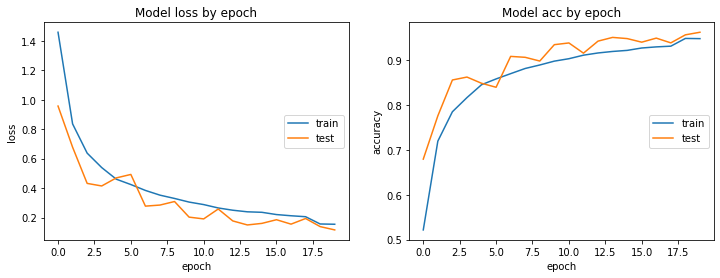

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_LeNet1.history['loss'])
plt.plot(history_LeNet1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_LeNet1.history['accuracy'])
plt.plot(history_LeNet1.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_LeNet1 = model_LeNet1.predict(X_valid)

test_pred_LeNet1_class = test_pred_LeNet1.argmax(axis = 1)

In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_LeNet1_label = (pd.DataFrame(test_pred_LeNet1_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_LeNet1_label))

              precision    recall  f1-score   support

       Apple       0.94      0.96      0.95      1943
   Blueberry       0.96      0.96      0.96       454
      Cherry       0.98      0.95      0.96       877
        Corn       0.99      0.98      0.98      1829
       Grape       1.00      0.98      0.99      1805
      Orange       0.99      0.96      0.98       503
       Peach       0.98      0.89      0.93       891
      Pepper       0.97      0.86      0.92       975
      Potato       0.89      0.99      0.93      1426
   Raspberry       0.98      0.96      0.97       445
     Soybean       0.94      0.94      0.94       505
      Squash       0.96      0.99      0.98       434
  Strawberry       0.97      0.98      0.98       900
      Tomato       0.96      0.98      0.97      4585

    accuracy                           0.96     17572
   macro avg       0.96      0.96      0.96     17572
weighted avg       0.96      0.96      0.96     17572



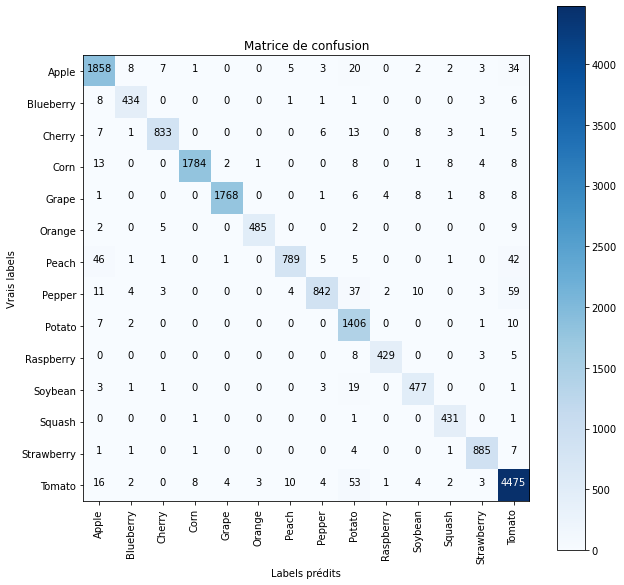

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_LeNet1_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

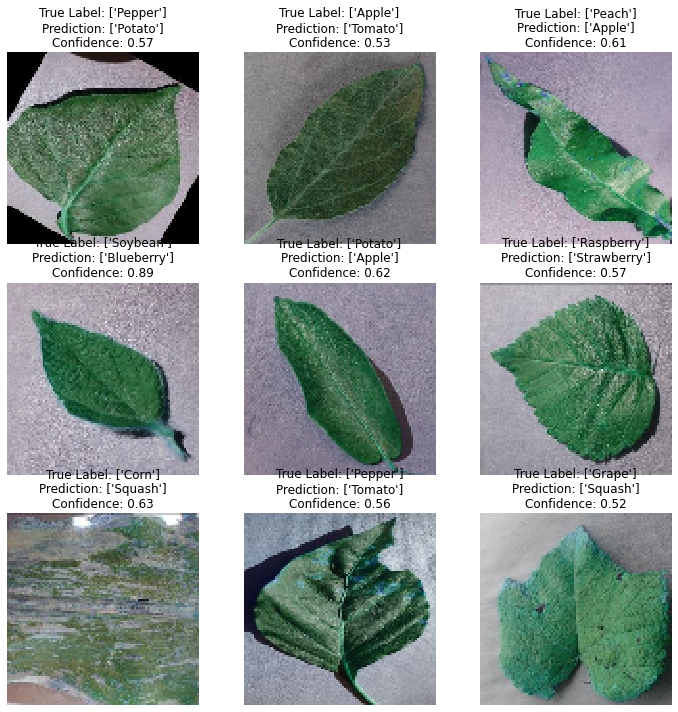

In [ ]:
# voir les images de la base de test où le modele se trompe

plt.subplots(3, 3, figsize=(12, 12))

error_indexes = []
for i in range(len(test_pred_LeNet1)):
    if (test_pred_LeNet1_label[i] != y_valid_label[i]):
      error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 9):
    img = X_valid[i] 
    img = img.reshape(100, 100,3)
    
    plt.subplot(3, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_valid_label[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_LeNet1_label[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred_LeNet1[i,test_pred_LeNet1_class[i]], 2)))

# 4e Modele  - Modele avec Ajustement des donnees desequilibrees (class Weights)

#### Architecture Lenet

In [ ]:
weights={0:	0.65, 1: 2.76, 2: 1.43, 3: 0.69, 4:0.70, 5:2.50, 6:1.41, 7:1.29,
         8:0.88, 9: 2.82, 10:2.48, 11: 2.89, 12: 1.40, 13: 0.27}

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_LeNet2 = Sequential()
model_LeNet2.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(3, 3)))
model_LeNet2.add(Dropout(rate=0.2))
model_LeNet2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet2.add(Dropout(rate=0.2))
model_LeNet2.add(Flatten())
model_LeNet2.add(Dense(units=64, activation='relu'))
model_LeNet2.add(Dense(units=14, activation='softmax'))

In [ ]:
model_LeNet2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_LeNet2.summary()

In [ ]:
history_LeNet2 = model_LeNet2.fit_generator(generator = training_data, 
                              epochs = 15,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau],
                              class_weight=weights)

####  Performances du modèle:

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_LeNet2.history['loss'])
plt.plot(history_LeNet2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_LeNet2.history['accuracy'])
plt.plot(history_LeNet2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Classification Report et Matrice de confusion

In [ ]:
test_pred_LeNet2 = model_LeNet2.predict(X_valid)

test_pred_LeNet2_class = test_pred_LeNet2.argmax(axis = 1)
# y_test_class = y_test.argmax(axis = 1)


In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_LeNet2_label = (pd.DataFrame(test_pred_LeNet2_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label , test_pred_LeNet2_label))

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_LeNet2_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

# 5e Modele: Architecture LeNet avec generateur d'images / UnderSampling

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_LeNet1_ru = Sequential()
model_LeNet1_ru.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_LeNet1_ru.add(MaxPooling2D(pool_size=(3, 3)))
model_LeNet1_ru.add(Dropout(rate=0.2))
model_LeNet1_ru.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1_ru.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1_ru.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1_ru.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1_ru.add(Dropout(rate=0.2))
model_LeNet1_ru.add(Flatten())
model_LeNet1_ru.add(Dense(units=64, activation='relu'))
model_LeNet1_ru.add(Dense(units=14, activation='softmax'))

In [ ]:
model_LeNet1_ru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_LeNet1_ru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 30)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 30)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)       

In [ ]:
history_LeNet1_ru = model_LeNet1_ru.fit_generator(generator = training_data_ru2, 
                              epochs = 50,
                              steps_per_epoch = len(X_train_ru2)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
168/168 [==============================] - 157s 931ms/step - loss: 2.1879 - accuracy: 0.2708 - val_loss: 1.7736 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 2/50
168/168 [==============================] - 155s 923ms/step - loss: 1.4952 - accuracy: 0.5157 - val_loss: 1.2519 - val_accuracy: 0.5923 - lr: 0.0010
Epoch 3/50
168/168 [==============================] - 155s 925ms/step - loss: 1.1328 - accuracy: 0.6346 - val_loss: 1.1669 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 4/50
168/168 [==============================] - 154s 918ms/step - loss: 0.9592 - accuracy: 0.6880 - val_loss: 1.1721 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 5/50
168/168 [==============================] - 155s 922ms/step - loss: 0.8569 - accuracy: 0.7199 - val_loss: 1.0435 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 6/50
168/168 [==============================] - 155s 920ms/step - loss: 0.7822 - accuracy: 0.7449 - val_loss: 1.0876 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 7/50
168/168 [==========================

In [ ]:
model_LeNet1_ru.save('/content/drive/MyDrive/model_LeNet1_ru')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_LeNet1_ru/assets


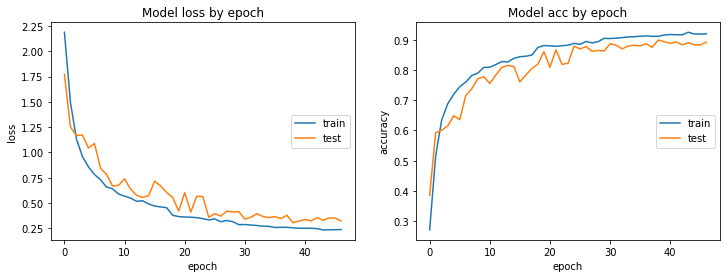

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_LeNet1_ru.history['loss'])
plt.plot(history_LeNet1_ru.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_LeNet1_ru.history['accuracy'])
plt.plot(history_LeNet1_ru.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_LeNet1_ru = model_LeNet1_ru.predict(X_valid)

test_pred_LeNet1_ru_class = test_pred_LeNet1_ru.argmax(axis = 1)

In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_LeNet1_ru_label = (pd.DataFrame(test_pred_LeNet1_ru_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_LeNet1_ru_label))

              precision    recall  f1-score   support

       Apple       0.93      0.73      0.82      1943
   Blueberry       0.85      0.94      0.90       454
      Cherry       0.91      0.90      0.91       877
        Corn       0.98      0.94      0.96      1829
       Grape       0.93      0.98      0.95      1805
      Orange       0.98      0.95      0.96       503
       Peach       0.91      0.92      0.91       891
      Pepper       0.84      0.83      0.84       975
      Potato       0.76      0.93      0.84      1426
   Raspberry       0.85      0.98      0.91       445
     Soybean       0.86      0.93      0.90       505
      Squash       0.84      0.99      0.91       434
  Strawberry       0.90      0.97      0.93       900
      Tomato       0.92      0.88      0.90      4585

    accuracy                           0.90     17572
   macro avg       0.89      0.92      0.90     17572
weighted avg       0.90      0.90      0.90     17572



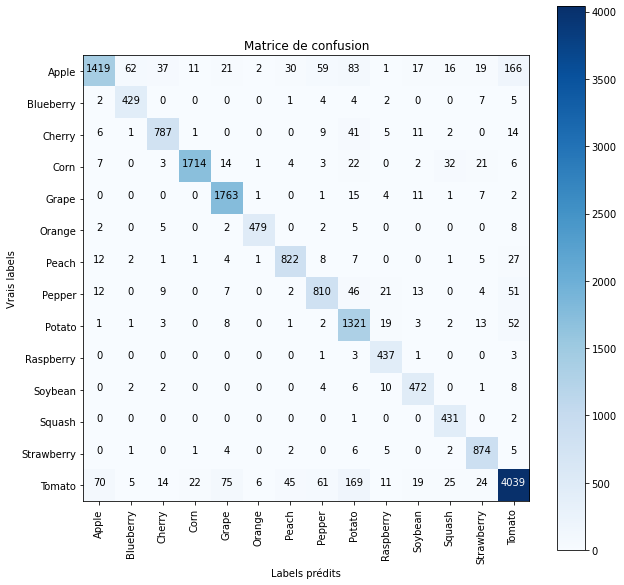

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_LeNet1_ru_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

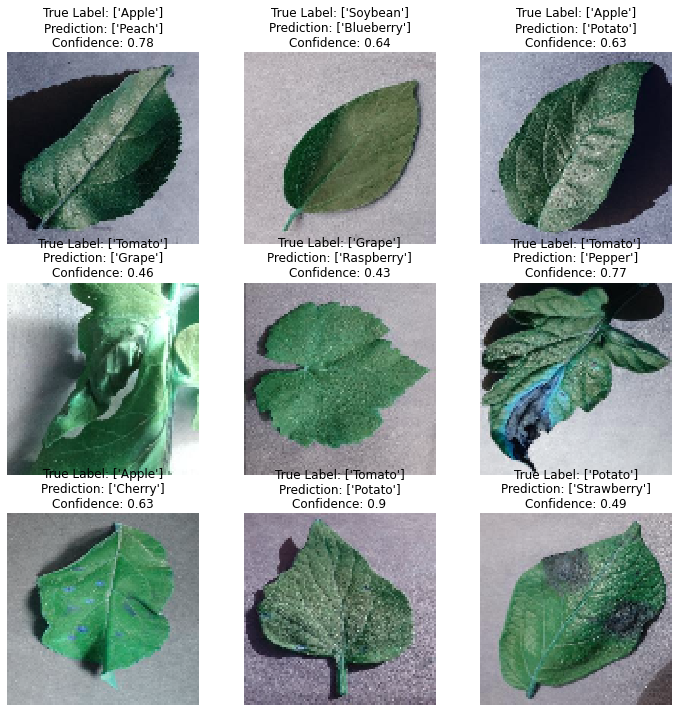

In [ ]:
# voir les images de la base de test où le modele se trompe

plt.subplots(3, 3, figsize=(12, 12))

error_indexes = []
for i in range(len(test_pred_LeNet1_ru)):
    if (test_pred_LeNet1_ru_label[i] != y_valid_label[i]):
      error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 9):
    img = X_valid[i] 
    img = img.reshape(100, 100,3)
    
    plt.subplot(3, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_valid_label[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_LeNet1_ru_label[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred_LeNet1_ru[i,test_pred_LeNet1_ru_class[i]], 2)))

# 6e Modele  - CNN pretrained on VGG6Net / Undersampling

#### Definition, Compilation et entrainement du modele

In [ ]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model_VGG16 = Sequential()
model_VGG16.add(base_model) # Ajout du modèle VGG16
model_VGG16.add(GlobalAveragePooling2D()) 
model_VGG16.add(Dense(1024,activation='relu'))
model_VGG16.add(Dropout(rate=0.2))
model_VGG16.add(Dense(512, activation='relu'))
model_VGG16.add(Dropout(rate=0.2))
model_VGG16.add(Dense(14, activation='softmax'))

model_VGG16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
history_VGG16 = model_VGG16.fit_generator(generator = training_data_ru, 
                              epochs = 10,
                              steps_per_epoch = len(X_train_ru2)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
168/168 [==============================] - 1826s 11s/step - loss: 1.1480 - acc: 0.6269 - val_loss: 0.7010 - val_acc: 0.7656 - lr: 0.0010
Epoch 2/10
168/168 [==============================] - 1813s 11s/step - loss: 0.6486 - acc: 0.7849 - val_loss: 0.5952 - val_acc: 0.7963 - lr: 0.0010
Epoch 3/10
168/168 [==============================] - 1879s 11s/step - loss: 0.5603 - acc: 0.8130 - val_loss: 0.5203 - val_acc: 0.8261 - lr: 0.0010
Epoch 4/10
168/168 [==============================] - 1823s 11s/step - loss: 0.4911 - acc: 0.8363 - val_loss: 0.3914 - val_acc: 0.8706 - lr: 0.0010
Epoch 5/10
168/168 [==============================] - 1798s 11s/step - loss: 0.4517 - acc: 0.8495 - val_loss: 0.4679 - val_acc: 0.8435 - lr: 0.0010
Epoch 6/10
168/168 [==============================] - 1870s 11s/step - loss: 0.4412 - acc: 0.8545 - val_loss: 0.4297 - val_acc: 0.8529 - lr: 0.0010
Epoch 7/10
168/168 [==============================] - 1879s 11s/step - loss: 0.4070 - acc: 0.8602 - val_loss: 0.

####  Performances du modèle:

KeyError: ignored

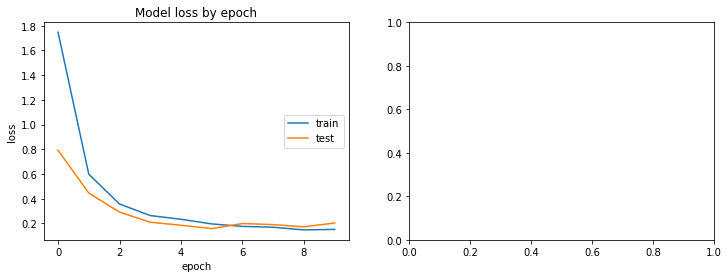

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_VGG16.history['acc'])
plt.plot(history_VGG16.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Classification Report et Matrice de confusion

In [ ]:
test_pred_VGG16 = model_VGG16.predict(X_valid)

test_pred_VGG16_class = test_pred_VGG16.argmax(axis = 1)
# y_test_class = y_test.argmax(axis = 1)


In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_VGG16_label = (pd.DataFrame(test_pred_VGG16_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label , test_pred_VGG16_label))

              precision    recall  f1-score   support

       Apple       0.85      0.71      0.78      1943
   Blueberry       0.62      0.98      0.76       454
      Cherry       0.92      0.88      0.90       877
        Corn       0.99      0.97      0.98      1829
       Grape       0.96      0.95      0.96      1805
      Orange       0.73      0.98      0.84       503
       Peach       0.88      0.92      0.90       891
      Pepper       0.76      0.89      0.82       975
      Potato       0.66      0.93      0.77      1426
   Raspberry       0.85      0.92      0.88       445
     Soybean       0.94      0.79      0.86       505
      Squash       0.96      0.94      0.95       434
  Strawberry       0.86      0.93      0.89       900
      Tomato       0.98      0.80      0.88      4585

    accuracy                           0.87     17572
   macro avg       0.85      0.90      0.87     17572
weighted avg       0.89      0.87      0.88     17572



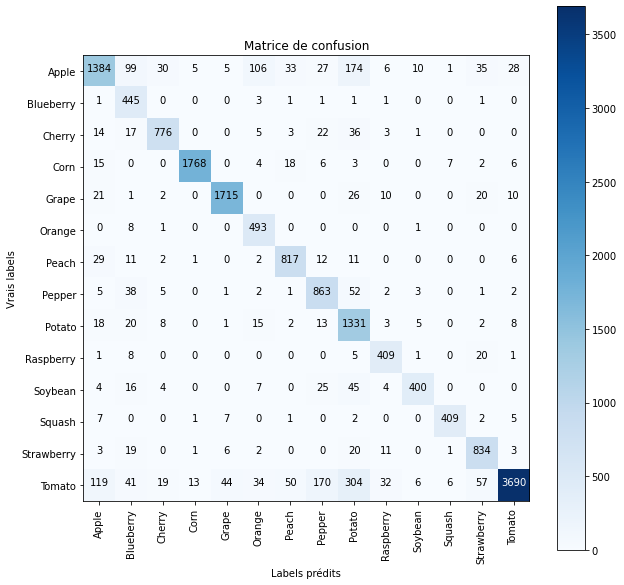

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_VGG16_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

list_labels = ['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato']

list_indexes = np.arange(14)

plt.yticks(list_indexes, list_labels)
plt.xticks(list_indexes,list_labels,
                  rotation = 90)

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

## on defreeze les 4 premieres couches

In [ ]:
#on defrseeze les 4 premieres couches
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
model_VGG16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
history_VGG16 = model_VGG16.fit_generator(generator = training_data_ru, 
                              epochs = 10,
                              steps_per_epoch = len(X_train_ru2)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
168/168 [==============================] - 1891s 11s/step - loss: 1.7469 - accuracy: 0.3892 - val_loss: 0.7915 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 2/10
168/168 [==============================] - 1977s 12s/step - loss: 0.5982 - accuracy: 0.8049 - val_loss: 0.4452 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 3/10
168/168 [==============================] - 1977s 12s/step - loss: 0.3567 - accuracy: 0.8890 - val_loss: 0.2915 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 4/10
168/168 [==============================] - 1968s 12s/step - loss: 0.2633 - accuracy: 0.9179 - val_loss: 0.2094 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 5/10
168/168 [==============================] - 1956s 12s/step - loss: 0.2332 - accuracy: 0.9296 - val_loss: 0.1851 - val_accuracy: 0.9422 - lr: 0.0010
Epoch 6/10
168/168 [==============================] - 1933s 12s/step - loss: 0.1956 - accuracy: 0.9393 - val_loss: 0.1577 - val_accuracy: 0.9526 - lr: 0.0010
Epoch 7/10
168/168 [==============================] 

In [ ]:
model_VGG16.save('/content/drive/MyDrive/model_VGG16')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_VGG16/assets


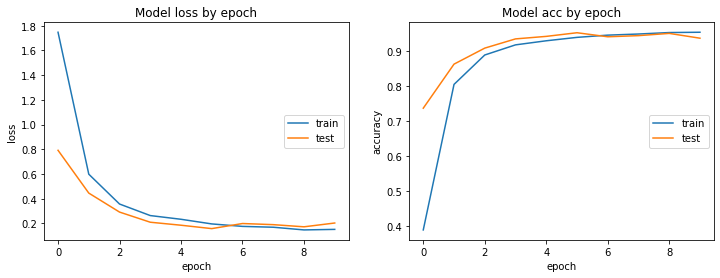

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

#### Classification Report et Matrice de confusion

In [ ]:
test_pred_VGG16 = model_VGG16.predict(X_valid)

test_pred_VGG16_class = test_pred_VGG16.argmax(axis = 1)
# y_test_class = y_test.argmax(axis = 1)


In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_VGG16_label = (pd.DataFrame(test_pred_VGG16_class, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()
y_valid_label = (pd.DataFrame(y_valid, columns=['categorie'])).replace({"categorie": dict_categorie}).to_numpy()


In [ ]:
print(metrics.classification_report(y_valid_label , test_pred_VGG16_label))

              precision    recall  f1-score   support

       Apple       0.97      0.77      0.86      1943
   Blueberry       0.88      0.97      0.92       454
      Cherry       0.86      0.99      0.92       877
        Corn       1.00      0.99      0.99      1829
       Grape       0.99      1.00      0.99      1805
      Orange       0.89      1.00      0.94       503
       Peach       0.89      0.96      0.92       891
      Pepper       0.89      0.96      0.92       975
      Potato       0.81      0.96      0.88      1426
   Raspberry       0.93      0.99      0.96       445
     Soybean       0.85      1.00      0.92       505
      Squash       0.99      0.99      0.99       434
  Strawberry       0.93      0.99      0.96       900
      Tomato       0.99      0.90      0.94      4585

    accuracy                           0.94     17572
   macro avg       0.92      0.96      0.94     17572
weighted avg       0.94      0.94      0.94     17572



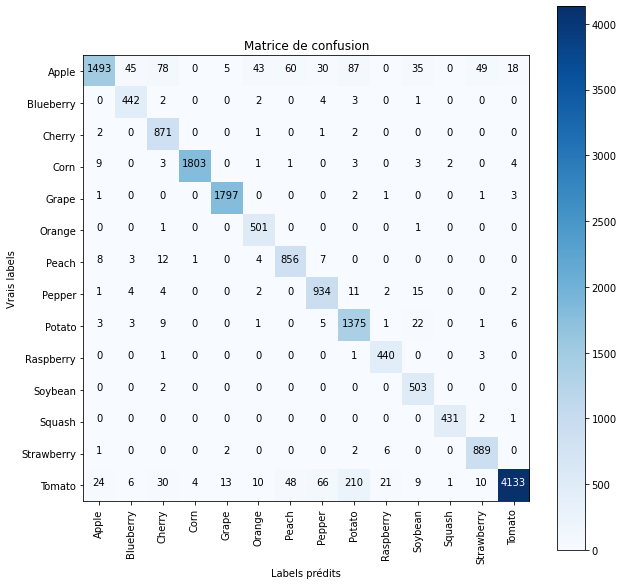

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_VGG16_label)

classes = range(0,14)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

list_labels = ['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato']

list_indexes = np.arange(14)

plt.yticks(list_indexes, list_labels)
plt.xticks(list_indexes,list_labels,
                  rotation = 90)

plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                              'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                              'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

# Double classification: is Healthy/Categorie deplante

#### Data processing

In [ ]:
y3_train0=((y2_train0=="healthy")*1).astype('int')
y3_valid0=((y2_valid0=="healthy")*1).astype('int')

y4_train0 = [x+"_"+ str(y) for (x, y) in zip(y_train0, y3_train0)]
y4_valid0 = [x+"_"+ str(y) for (x, y) in zip(y_valid0, y3_valid0)]


In [ ]:
pd.DataFrame(y4_train0).value_counts()

Tomato_0                     16419
Apple_0                       5763
Grape_0                       5530
Corn_(maize)_0                5457
Potato_0                      3878
Soybean_1                     2022
Orange_0                      2010
Apple_1                       2008
Pepper,_bell_1                1988
Tomato_1                      1926
Pepper,_bell_0                1913
Corn_(maize)_1                1859
Peach_0                       1838
Cherry_(including_sour)_1     1826
Potato_1                      1824
Strawberry_1                  1824
Blueberry_1                   1816
Raspberry_1                   1781
Strawberry_0                  1774
Squash_0                      1736
Peach_1                       1728
Grape_1                       1692
Cherry_(including_sour)_0     1683
dtype: int64

In [ ]:
encoder2 =  LabelEncoder()
y4_train = encoder2.fit_transform(y4_train0)
y4_valid = encoder2.transform(y4_valid0)

In [ ]:
batch_size = 100

training_data_model2 = train_data_generator.flow(X_train, y4_train, batch_size=batch_size)
test_data_model2 = test_data_generator.flow(X_valid, y4_valid, batch_size=batch_size)

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_LeNet2 = Sequential()
model_LeNet2.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(3, 3)))
model_LeNet2.add(Dropout(rate=0.2))
model_LeNet2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet2.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet2.add(Dropout(rate=0.2))
model_LeNet2.add(Flatten())
model_LeNet2.add(Dense(units=64, activation='relu'))
model_LeNet2.add(Dense(units=23, activation='softmax')) #ML Essai softmax ala place de sigmoid

In [ ]:
model_LeNet2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_LeNet2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 30)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        1

In [ ]:
history_LeNet2 = model_LeNet2.fit_generator(generator = training_data_model2, 
                              epochs = 25,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data_model2,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
702/702 [==============================] - 395s 561ms/step - loss: 1.7933 - accuracy: 0.4581 - val_loss: 0.9365 - val_accuracy: 0.7087 - lr: 0.0010
Epoch 2/25
702/702 [==============================] - 397s 566ms/step - loss: 0.9348 - accuracy: 0.6964 - val_loss: 0.6280 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 3/25
702/702 [==============================] - 399s 568ms/step - loss: 0.7080 - accuracy: 0.7718 - val_loss: 0.5188 - val_accuracy: 0.8327 - lr: 0.0010
Epoch 4/25
702/702 [==============================] - 398s 567ms/step - loss: 0.5890 - accuracy: 0.8077 - val_loss: 0.4089 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 5/25
702/702 [==============================] - 399s 568ms/step - loss: 0.5068 - accuracy: 0.8323 - val_loss: 0.3528 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 6/25
702/702 [==============================] - 398s 566ms/step - loss: 0.4591 - accuracy: 0.8477 - val_loss: 0.4001 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 7/25
702/702 [==========================

In [ ]:

model_LeNet2.save('/content/drive/MyDrive/model_LeNet_healthy_categorie')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_LeNet_healthy_categorie/assets


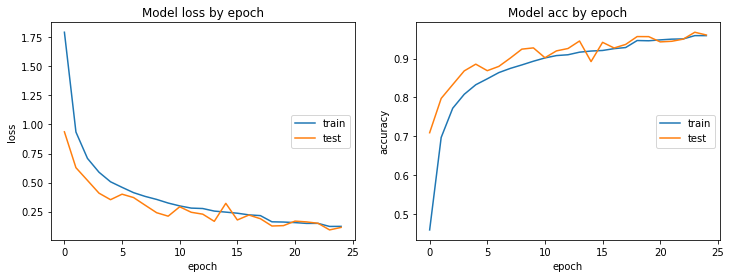

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_LeNet2.history['loss'])
plt.plot(history_LeNet2.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_LeNet2.history['accuracy'])
plt.plot(history_LeNet2.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_LeNet2 = model_LeNet2.predict(X_valid)

test_pred_LeNet2_class = test_pred_LeNet2.argmax(axis = 1)

In [ ]:
# on met les labels pour que ce soit plus facile a lire
test_pred_LeNet2_label = encoder2.inverse_transform(test_pred_LeNet2_class)
y4_valid_label()

In [ ]:
print(metrics.classification_report(y4_valid0, test_pred_LeNet2_label))

                           precision    recall  f1-score   support

                  Apple_0       0.96      0.95      0.95      1441
                  Apple_1       0.92      0.97      0.94       502
              Blueberry_1       0.93      0.98      0.96       454
Cherry_(including_sour)_0       0.95      0.97      0.96       421
Cherry_(including_sour)_1       0.95      0.96      0.96       456
           Corn_(maize)_0       0.99      0.99      0.99      1364
           Corn_(maize)_1       1.00      0.98      0.99       465
                  Grape_0       0.99      1.00      0.99      1382
                  Grape_1       1.00      0.99      0.99       423
                 Orange_0       0.99      0.96      0.97       503
                  Peach_0       0.98      0.88      0.93       459
                  Peach_1       0.98      0.99      0.99       432
           Pepper,_bell_0       0.99      0.91      0.95       478
           Pepper,_bell_1       0.95      0.86      0.90     

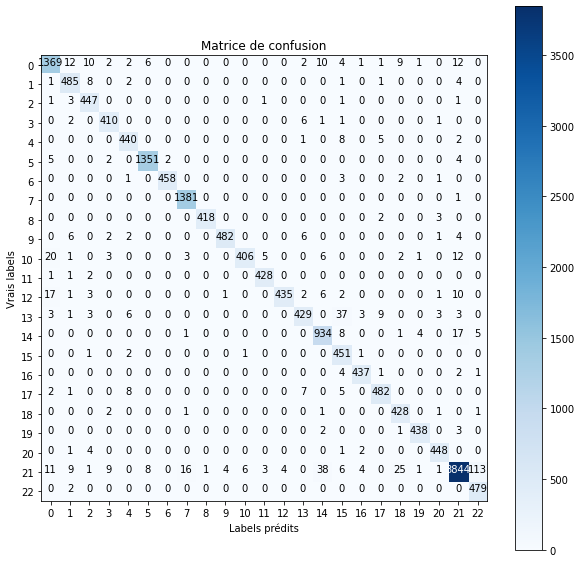

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y4_valid0, test_pred_LeNet2_label)

classes = range(0,23)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

# plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
#                                               'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
plt.ylabel('Vrais labels')
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
#                                               'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                  # rotation = 90)

plt.xlabel('Labels prédits')

plt.show()